### This cell is only to make pulling changes easy in google colab

In [ ]:
!git pull origin main

---

In [ ]:
%pip install ultralytics
%pip install supervision

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
import pickle
import cv2
import sys
import pandas as pd
from sklearn.cluster import KMeans

---

## if You fork make an .env file and then run this cell

In [ ]:
%pip install python-dotenv
from dotenv import load_dotenv

load_dotenv()

GITHUB_REPO_LINK_FOOTBALL_VISION_STATS = os.getenv("GITHUB_REPO_LINK_FOOTBALL_VISION_STATS")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


---

# Exacute the cells and instractions with this Header if you want to train on Google Colab

## Only on Google colab

In [ ]:
!git clone {GITHUB_REPO_LINK_FOOTBALL_VISION_STATS}
#Put your GitHub repo link here OR in .env file

In [ ]:
os.chdir('/content/Football-Vision-Stats-ML')
os.chdir('Football Advanced stats with python')
!ls

---

### Here You Choose the Model To TRAIN

In [7]:
PLAYER_DETECTION_MODEL = YOLO("yolo11m.pt")

---

### Quick Model Capabilites before training


0: 384x640 23 persons, 115.8ms
Speed: 2.3ms preprocess, 115.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


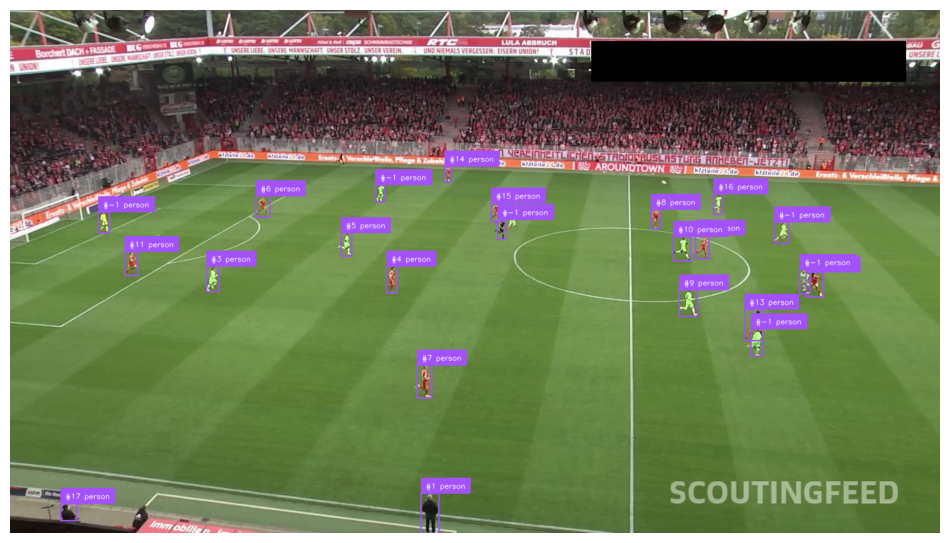

In [ ]:
SOURCE_VIDEO_PATH = "121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

tracker = sv.ByteTrack()
bounding_box = sv.BoxAnnotator()
label = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

results = PLAYER_DETECTION_MODEL(frame)[0]
detections = sv.Detections.from_ultralytics(results)

tracked_detections = tracker.update_with_detections(detections)

labels = [
    f"#{tracker_id} {class_name}"
    for class_name, tracker_id
    in zip(detections.data["class_name"], detections.tracker_id)
]

annotated_frame = bounding_box.annotate(frame.copy(), detections=detections)
annotated_frame = label.annotate(annotated_frame, detections=detections, labels=labels)
annotated_frame = trace_annotator.annotate(annotated_frame, detections=detections)

sv.plot_image(annotated_frame)



## This cell will run the model on the whole video - and it takes a bit of time

In [ ]:

tracker = sv.ByteTrack()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

bounding_box = sv.BoxAnnotator()
label = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()



def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = PLAYER_DETECTION_MODEL(frame)[0]
    detections = sv.Detections.from_ultralytics(results)

    tracked_pos = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {class_name}"
        for class_name, tracker_id
        in zip(detections.data["class_name"], detections.tracker_id)
    ]

    annotated_frame = bounding_box.annotate(
        frame.copy(), detections=detections)
    annotated_frame = label.annotate(
        annotated_frame, detections=detections, labels=labels)
    return trace_annotator.annotate(
        annotated_frame, detections=detections)

sv.process_video(source_path=SOURCE_VIDEO_PATH,
                target_path="results.mp4",
                callback=callback)


---

# Traning The Model

## Only on colab

In [ ]:
# Update Players_data.yaml with correct Colab paths
yaml_content = """train: /content/Football-Vision-Stats-ML/Football Advanced stats with python/football-players-detection/train
val: /content/Football-Vision-Stats-ML/Football Advanced stats with python/football-players-detection/valid
test: /content/Football-Vision-Stats-ML/Football Advanced stats with python/football-players-detection/test

nc: 4
names: ['ball', 'goalkeeper', 'player', 'referee']
"""

# Write the corrected YAML file
with open('Players_data.yaml', 'w') as f:
    f.write(yaml_content)

# Verify the fix
print("Updated YAML file:")
!cat Players_data.yaml

In [ ]:
results = PLAYER_DETECTION_MODEL.train(data="Players_data.yaml",
                                      epochs=150,
                                      imgsz=640)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Download the Trained Models from Drive/Colab to Local Folder

In [ ]:
!ls runs/detect/


---

In [2]:
TRAINED_DETECTION_MODEL = YOLO("Trained_Models/best.pt")

### Quick Model Capabilites AFTER training


0: 384x640 1 goalkeeper, 21 players, 2 referees, 167.5ms
Speed: 3.6ms preprocess, 167.5ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)


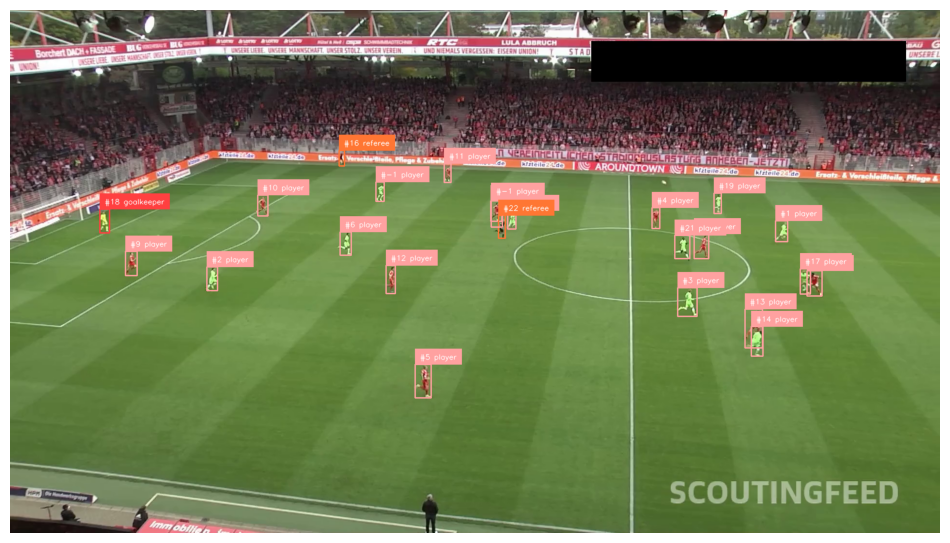

In [6]:
SOURCE_VIDEO_PATH = "121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

tracker = sv.ByteTrack()
bounding_box = sv.BoxAnnotator()
label = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

results = TRAINED_DETECTION_MODEL(frame)[0]
detections = sv.Detections.from_ultralytics(results)

tracked_detections = tracker.update_with_detections(detections)

labels = [
    f"#{tracker_id} {class_name}"
    for class_name, tracker_id
    in zip(detections.data["class_name"], detections.tracker_id)
]

annotated_frame = bounding_box.annotate(frame.copy(), detections=detections)
annotated_frame = label.annotate(annotated_frame, detections=detections, labels=labels)
annotated_frame = trace_annotator.annotate(annotated_frame, detections=detections)

sv.plot_image(annotated_frame)

### As you can notice its now separating Ref / Players / Goalie / Ball ( Not noticable in this frame )

---

# Features Time 

## 1. Reading and Saving Video

In [3]:

def read_video(PATH):
    cap = cv2.VideoCapture(PATH) # Capture object
    frames = [] # Empty list to store frames
    while True: # Loop while the video is opened
        ret, frame = cap.read() # Read a frame from the video
        if not ret:
            break
        frames.append(frame) # Append the frame to the list
    cap.release()
    return frames # Return the list of frames

def save_frames(output_frames, output_folder):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # Define the codec
    out = cv2.VideoWriter(output_folder, fourcc, 24.0, (output_frames[0].shape[1], output_frames[0].shape[0])) # Create VideoWriter object
    for frame in output_frames:
        out.write(frame) # Write the frame to the video
    out.release() # Release the VideoWriter object


In [8]:
os.makedirs("runs/output_videos", exist_ok=True)
video_frames = read_video("08fd33_0.mp4")
save_frames(video_frames, "runs/output_videos/output.avi")

---

## 2. Tracking bounding boxes

In [4]:
tracker = sv.ByteTrack()
def detect_frames(frames):
    batch_size = 20
    detections = []
    for i in range(0, len(frames), batch_size):
        detections_batch = TRAINED_DETECTION_MODEL.predict(frames[i:i+batch_size],conf=0.1)
        detections += detections_batch
        
    return detections

def get_object_tracks(frames, read_from_disk=False, track_path=None):

    if read_from_disk and track_path is not None and os.path.exists(track_path):
        with open(track_path, "rb") as f:
            tracked_objects = pickle.load(f)
            return tracked_objects

    detections = detect_frames(frames)
    tracked_objects = {
        "players": [],
        "referees": [],
        "ball": []
    }

    for frame_num, detections in enumerate(detections):
        cls_names = detections.names 
        cls_names_inv = {v: k for k, v in cls_names.items()}

        detections_supervision = sv.Detections.from_ultralytics(detections)
        for obj_id, class_id in enumerate(detections_supervision.class_id):
            if cls_names[class_id] == "goalkeeper":
                detections_supervision.class_id[obj_id] = cls_names_inv["player"]


        detection_with_tracks = tracker.update_with_detections(detections_supervision)

        tracked_objects["players"].append({})
        tracked_objects["referees"].append({})
        tracked_objects["ball"].append({})

        for frame_detection in detection_with_tracks:
            bbox = frame_detection[0].tolist()
            class_id = frame_detection[3]
            track_id = frame_detection[4]

            if class_id == cls_names_inv["player"]:
                tracked_objects["players"][frame_num][track_id] = {
                    "bbox": bbox,
                    "class_id": class_id,
                    "frame": frame_num
                }
            elif class_id == cls_names_inv["referee"]:
                tracked_objects["referees"][frame_num][track_id] = {
                    "bbox": bbox,
                    "class_id": class_id,
                    "frame": frame_num
                }
         
        for frame_detection in detection_with_tracks:
            bbox = frame_detection[0].tolist()
            class_id = frame_detection[3]

            if class_id == cls_names_inv["ball"]:
                tracked_objects["ball"][frame_num][1] = {"bbox": bbox}

        if track_path is not None:
            with open(track_path, "wb") as f:
                pickle.dump(tracked_objects, f)

    return tracked_objects


In [15]:

video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")
save_frames(video_frames, "runs/output_videos/output_tracker_first_save.avi")


0: 384x640 2 goalkeepers, 23 players, 3 referees, 106.0ms
1: 384x640 2 goalkeepers, 23 players, 3 referees, 106.0ms
2: 384x640 1 goalkeeper, 23 players, 2 referees, 106.0ms
3: 384x640 1 goalkeeper, 21 players, 1 referee, 106.0ms
4: 384x640 1 goalkeeper, 20 players, 1 referee, 106.0ms
5: 384x640 1 goalkeeper, 22 players, 1 referee, 106.0ms
6: 384x640 1 goalkeeper, 22 players, 1 referee, 106.0ms
7: 384x640 1 goalkeeper, 23 players, 1 referee, 106.0ms
8: 384x640 1 goalkeeper, 24 players, 106.0ms
9: 384x640 1 goalkeeper, 21 players, 1 referee, 106.0ms
10: 384x640 1 goalkeeper, 20 players, 1 referee, 106.0ms
11: 384x640 1 goalkeeper, 18 players, 2 referees, 106.0ms
12: 384x640 1 goalkeeper, 16 players, 4 referees, 106.0ms
13: 384x640 1 goalkeeper, 17 players, 1 referee, 106.0ms
14: 384x640 1 ball, 1 goalkeeper, 17 players, 2 referees, 106.0ms
15: 384x640 1 ball, 1 goalkeeper, 19 players, 1 referee, 106.0ms
16: 384x640 1 goalkeeper, 14 players, 1 referee, 106.0ms
17: 384x640 1 goalkeeper, 1

### Drawing annotations

In [16]:
def get_center_bbox(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2), int((y1+y2)/2)

def get_width_bbox(bbox):
    return bbox[2]-bbox[0]

def draw_ellipse(frame,bbox,color,track_id):
    y2 = int(bbox[3])
    x_center, _ = get_center_bbox(bbox)
    width = get_width_bbox(bbox)

    cv2.ellipse(frame, center=(x_center, y2), axes= (int(width) , int(0.35 * width)),angle=0, startAngle=-45,endAngle=235,color=color, thickness=4, lineType=cv2.LINE_4) 

    rectangle_width = 40
    rectangle_height=20
    x1_rect = x_center - rectangle_width//2
    x2_rect = x_center + rectangle_width//2
    y1_rect = (y2- rectangle_height//2) +15
    y2_rect = (y2+ rectangle_height//2) +15

    if track_id is not None:
        cv2.rectangle(frame,
                        (int(x1_rect),int(y1_rect) ),
                        (int(x2_rect),int(y2_rect)),
                        color,
                        cv2.FILLED)
        
        x1_text = x1_rect+12
        if track_id > 99:
            x1_text -=10
        
        cv2.putText(
            frame,
            f"{track_id}",
            (int(x1_text),int(y1_rect+15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0,0,0),
            2
        )

        return frame
    

def measure_distance(p1,p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

def measure_xy_distance(p1,p2):
    return p1[0]-p2[0],p1[1]-p2[1]

def get_foot_position(bbox):
    x1,y1,x2,y2 = bbox
    return int((x1+x2)/2),int(y2)

def draw_triangle(frame,bbox,color):
    y= int(bbox[1])
    x,_ = get_center_bbox(bbox)

    triangle_points = np.array([
        [x,y],
        [x-10,y-20],
        [x+10,y-20],
    ])
    cv2.drawContours(frame, [triangle_points],0,color, cv2.FILLED)
    cv2.drawContours(frame, [triangle_points],0,(0,0,0), 2)

    return frame

def draw_annotations(video_frames, tracked_objects):
    output_video_frames = []
    for frame_num, frame in enumerate(video_frames):
        frame = frame.copy()

        player_dict = tracked_objects["players"][frame_num]
        ball_dict = tracked_objects["ball"][frame_num]
        referee_dict = tracked_objects["referees"][frame_num]

        for track_id, player in player_dict.items():
            color = player.get('team_color', (0, 0, 255))  # Default to red if no team color is assigned
            frame = draw_ellipse(frame, player["bbox"], color, track_id)

            if player.get('has_ball', False):
               frame = draw_triangle(frame, player["bbox"], (0, 0, 255))

        for track_id, referee in referee_dict.items():
            frame = draw_ellipse(frame, referee["bbox"], (255, 0, 0), track_id)

        for track_id, ball in ball_dict.items():
            frame = draw_triangle(frame, ball["bbox"], (0, 255, 0))

        output_video_frames.append(frame)

    return output_video_frames


In [18]:

video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")
output_video_frames = draw_annotations(video_frames, tracked_objects)
save_frames(output_video_frames, "runs/output_videos/output_tracker_annotations.avi")

---

## Team Color seprating

In [19]:
# First save cropped frame of player

os.makedirs("runs/cropped_players", exist_ok=True)
for track_id, player in tracked_objects['players'][0].items():
    bbox = player['bbox']
    frame = video_frames[0]

    # Convert bbox coordinates to integers
    x1, y1, x2, y2 = map(int, bbox)
    cropped_image = frame[y1:y2, x1:x2]
    cv2.imwrite(f"runs/cropped_players/player_{track_id}_cropped.jpg", cropped_image)
    break



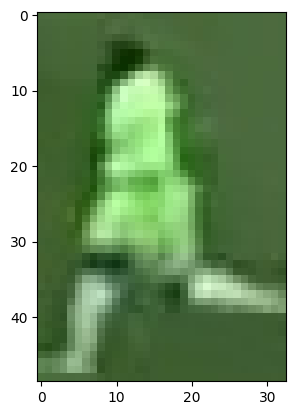

In [20]:
image_path = "runs/cropped_players/player_1_cropped.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

## We only need the top half of the image

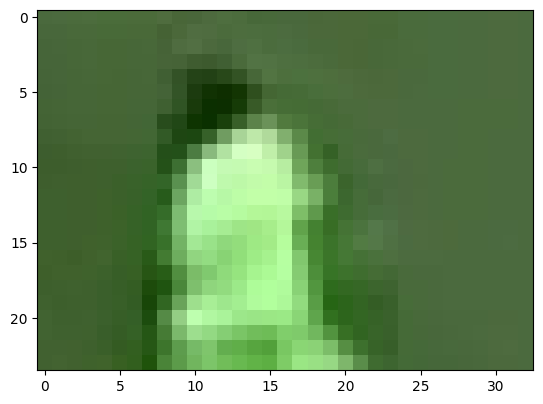

In [21]:
top_half_image = image[0:image.shape[0]//2, 0:image.shape[1]]
plt.imshow(top_half_image)
plt.show()

## Now We are going to Cluster colors so we can have the avg of shirt color

In [22]:
team_colors = {}
player_team_dict = {}
kmeans = KMeans(n_clusters=2, init="k-means++",n_init=10)


def get_clustering_model(image):
        # Reshape the image to 2D array
        image_2d = image.reshape(-1,3)

        # Preform K-means with 2 clusters
        kmeans = KMeans(n_clusters=2, init="k-means++",n_init=1)
        kmeans.fit(image_2d)

        return kmeans

def get_player_color(frame, bbox):
    
        image = frame[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]

        top_half_image = image[0:int(image.shape[0]/2),:]

        # Get Clustering model
        kmeans = get_clustering_model(top_half_image)

        # Get the cluster labels forr each pixel
        labels = kmeans.labels_

        # Reshape the labels to the image shape
        clustered_image = labels.reshape(top_half_image.shape[0],top_half_image.shape[1])

        # Get the player cluster
        corner_clusters = [clustered_image[0,0],clustered_image[0,-1],clustered_image[-1,0],clustered_image[-1,-1]]
        non_player_cluster = max(set(corner_clusters),key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        player_color = kmeans.cluster_centers_[player_cluster]

        return player_color


def assign_team_color(frame, player_detections):
    player_colors = []
    for _, player_detection in player_detections.items():
        bbox = player_detection["bbox"]
        player_color =  get_player_color(frame,bbox)
        player_colors.append(player_color)

    kmeans.fit(player_colors)

    team_colors[1] = kmeans.cluster_centers_[0]
    team_colors[2] = kmeans.cluster_centers_[1]


def get_player_team(frame,player_bbox,player_id):
    if player_id in player_team_dict:
        return player_team_dict[player_id]

    player_color = get_player_color(frame,player_bbox)

    team_id = kmeans.predict(player_color.reshape(1,-1))[0]
    team_id+=1

    player_team_dict[player_id] = team_id

    return team_id

## Now we have teams colors, we can now procced with making teams

In [24]:
video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")

assign_team_color(video_frames[0], tracked_objects['players'][0])
for frame_num, player_track in enumerate(tracked_objects['players']):
        for player_id, track in player_track.items():
            team = get_player_team(video_frames[frame_num],   
                                                 track['bbox'],
                                                 player_id)
            tracked_objects['players'][frame_num][player_id]['team'] = team 
            tracked_objects['players'][frame_num][player_id]['team_color'] = team_colors[team]

output_video_frames = draw_annotations(video_frames, tracked_objects)
save_frames(output_video_frames, "runs/output_videos/output_tracker_team_color_clustering.avi")

---

## Now Were going to work on ball detaction

In [25]:
def interpolate_ball_position(ball_position):
    ball_position = [x.get(1,{}).get('bbox',[]) for x in ball_position]
    df_ball_position = pd.DataFrame(ball_position, columns=['x1', 'y1', 'x2', 'y2'])
    df_ball_position = df_ball_position.interpolate()
    df_ball_position = df_ball_position.bfill()
    ball_position = [{1: {"bbox":x}} for x in df_ball_position.to_numpy().tolist()]
    return ball_position


In [ ]:
video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")

# TODO re-add only after transition to yolov8x
# tracked_objects["ball"] = interpolate_ball_position(tracked_objects["ball"])

assign_team_color(video_frames[0], tracked_objects['players'][0])
for frame_num, player_track in enumerate(tracked_objects['players']):
        for player_id, track in player_track.items():
            team = get_player_team(video_frames[frame_num],   
                                                 track['bbox'],
                                                 player_id)
            tracked_objects['players'][frame_num][player_id]['team'] = team 
            tracked_objects['players'][frame_num][player_id]['team_color'] = team_colors[team]

output_video_frames = draw_annotations(video_frames, tracked_objects)
save_frames(output_video_frames, "runs/output_videos/output_tracker_ball_detection.avi")

---


## Player with ball assiganer

In [20]:

max_player_ball_distance = 50

def assign_ball_to_player(players, ball_bbox):
    ball_pos = get_center_bbox(ball_bbox)

    assigned_player = None
    min_distance = float('inf')

    for player_id, player in players.items():
        player_bbox = player['bbox']
        distance_left = measure_dist(player_bbox[0],player_bbox[-1],ball_pos)
        distance_right = measure_dist(player_bbox[2],player_bbox[-1],ball_pos)
        distance = min(distance_left,distance_right)

        if distance < min_distance and distance < max_player_ball_distance:
            min_distance = distance
            assigned_player = player_id

    return assigned_player


In [ ]:
video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")

#To re-add only after transition to yolov8x
# tracked_objects["ball"] = interpolate_ball_position(tracked_objects["ball"])

assign_team_color(video_frames[0], tracked_objects['players'][0])
for frame_num, player_track in enumerate(tracked_objects['players']):
        for player_id, track in player_track.items():
            team = get_player_team(video_frames[frame_num],   
                                                 track['bbox'],
                                                 player_id)
            tracked_objects['players'][frame_num][player_id]['team'] = team 
            tracked_objects['players'][frame_num][player_id]['team_color'] = team_colors[team]

# TODO re-add only after transition to yolov8x
# for frame_num, player_track in enumerate(tracked_objects['players']):
#      ball_bbox = tracked_objects['ball'][frame_num][1]['bbox']
#      player_assigned = assign_ball_to_player(player_track, ball_bbox)

#      if player_assigned != -1:
#            tracked_objects['players'][frame_num][player_assigned]['has_ball'] = True

output_video_frames = draw_annotations(video_frames, tracked_objects)
save_frames(output_video_frames, "runs/output_videos/output_tracker_player_with_ball.avi")

# TODO - To add team precntage of possiation 

# TODO - Add a mini map to video

---

# Camera movmenent and precpective

In [ ]:
minimum_distance = 5
lk_params = dict(
            winSize = (15,15),
            maxLevel = 2,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03)
        )

first_frame_grayscale = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
mask_features = np.zeros_like(first_frame_grayscale)
mask_features[:,0:20] = 1
mask_features[:,900:1050] = 1

features = dict(
    maxCorners = 100,
    qualityLevel = 0.3,
    minDistance =3,
    blockSize = 7,
    mask = mask_features
        )


def add_adjust_positions_to_tracks(tracks, camera_movement_per_frame):
        for object, object_tracks in tracked_objects.items():
            for frame_num, track in enumerate(object_tracks):
                for track_id, track_info in track.items():
                    position = track_info['position']
                    camera_movement = camera_movement_per_frame[frame_num]
                    position_adjusted = (position[0]-camera_movement[0],position[1]-camera_movement[1])
                    tracks[object][frame_num][track_id]['position_adjusted'] = position_adjusted
                    


def get_camera_movement(frames,read_from_stub=False, stub_path=None):
    
    if read_from_stub and stub_path is not None and os.path.exists(stub_path):
        with open(stub_path,'rb') as f:
            return pickle.load(f)

    camera_movement = [[0,0]]*len(frames)

    old_gray = cv2.cvtColor(frames[0],cv2.COLOR_BGR2GRAY)
    old_features = cv2.goodFeaturesToTrack(old_gray,**features)

    for frame_num in range(1,len(frames)):
        frame_gray = cv2.cvtColor(frames[frame_num],cv2.COLOR_BGR2GRAY)
        new_features, _,_ = cv2.calcOpticalFlowPyrLK(old_gray,frame_gray,old_features,None,**lk_params)

        max_distance = 0
        camera_movement_x, camera_movement_y = 0,0

        for i, (new,old) in enumerate(zip(new_features,old_features)):
            new_features_point = new.ravel()
            old_features_point = old.ravel()

            distance = measure_distance(new_features_point,old_features_point)
            if distance>max_distance:
                max_distance = distance
                camera_movement_x,camera_movement_y = measure_xy_distance(old_features_point, new_features_point ) 
        
        if max_distance > minimum_distance:
            camera_movement[frame_num] = [camera_movement_x,camera_movement_y]
            old_features = cv2.goodFeaturesToTrack(frame_gray,**features)

        old_gray = frame_gray.copy()
    
    if stub_path is not None:
        with open(stub_path,'wb') as f:
            pickle.dump(camera_movement,f)

    return camera_movement

def draw_camera_movement(frames, camera_movement_per_frame):
    output_frames=[]

    for frame_num, frame in enumerate(frames):
        frame= frame.copy()

        overlay = frame.copy()
        cv2.rectangle(overlay,(0,0),(500,100),(255,255,255),-1)
        alpha =0.6
        cv2.addWeighted(overlay,alpha,frame,1-alpha,0,frame)

        x_movement, y_movement = camera_movement_per_frame[frame_num]
        frame = cv2.putText(frame,f"Camera Movement X: {x_movement:.2f}",(10,30), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)
        frame = cv2.putText(frame,f"Camera Movement Y: {y_movement:.2f}",(10,60), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),3)

        output_frames.append(frame) 

    return output_frames


In [35]:
court_width = 68
court_length = 23.32

pixel_vertices = np.array([[110, 1035], 
                               [265, 275], 
                               [910, 260], 
                               [1640, 915]])
        
target_vertices = np.array([
            [0,court_width],
            [0, 0],
            [court_length, 0],
            [court_length, court_width]
        ])

pixel_vertices = pixel_vertices.astype(np.float32)
target_vertices = target_vertices.astype(np.float32)

persepctive_trasnformer = cv2.getPerspectiveTransform(pixel_vertices, target_vertices)

def transform_point(point):
    p = (int(point[0]),int(point[1]))
    is_inside = cv2.pointPolygonTest(pixel_vertices,p,False) >= 0 
    if not is_inside:
        return None

    reshaped_point = point.reshape(-1,1,2).astype(np.float32)
    tranform_point = cv2.perspectiveTransform(reshaped_point,persepctive_trasnformer)
    return tranform_point.reshape(-1,2)

def add_transformed_position_to_tracks(tracks):
    for object, object_tracks in tracks.items():
        for frame_num, track in enumerate(object_tracks):
            for track_id, track_info in track.items():
                position = track_info['position_adjusted']
                position = np.array(position)
                position_trasnformed = transform_point(position)
                if position_trasnformed is not None:
                    position_trasnformed = position_trasnformed.squeeze().tolist()
                tracks[object][frame_num][track_id]['position_transformed'] = position_trasnformed

---

# Speed and Distance estimator

In [36]:
frame_window = 5
frame_rate = 24
def add_speed_and_distance_to_tracks( tracks):
    total_distance = {}

    for object, object_tracks in tracked_objects.items():
        if object == "ball" or object == "referees":
            continue
        number_of_frames = len(object_tracks)
        for frame_num in range(0, number_of_frames, frame_window):
            last_frame = min(frame_num + frame_window, number_of_frames - 1)

            for track_id, _ in object_tracks[frame_num].items():
                if track_id not in object_tracks[last_frame]:
                    continue

                start_position = object_tracks[frame_num][track_id].get('position_transformed')
                end_position = object_tracks[last_frame][track_id].get('position_transformed')

                if start_position is None or end_position is None:
                    continue

                distance_covered = measure_dist(start_position, end_position)
                time_elapsed = (last_frame - frame_num) / frame_rate
                speed_meteres_per_second = distance_covered / time_elapsed
                speed_km_per_hour = speed_meteres_per_second * 3.6

                if object not in total_distance:
                    total_distance[object] = {}

                if track_id not in total_distance[object]:
                    total_distance[object][track_id] = 0

                total_distance[object][track_id] += distance_covered

                for frame_num_batch in range(frame_num, last_frame):
                    if track_id not in tracks[object][frame_num_batch]:
                        continue
                    tracks[object][frame_num_batch][track_id]['speed'] = speed_km_per_hour
                    tracks[object][frame_num_batch][track_id]['distance'] = total_distance[object][track_id]


def draw_speed_and_distance(frames, tracks):
    output_frames = []
    for frame_num, frame in enumerate(frames):
        for object, object_tracks in tracked_objects.items():
            if object == "ball" or object == "referees":
                continue
            for _, track_info in object_tracks[frame_num].items():
                if "speed" in track_info:
                    speed = track_info.get('speed', None)
                    distance = track_info.get('distance', None)
                    if speed is None or distance is None:
                        continue

                    bbox = track_info['bbox']
                    position = get_foot_position(bbox)
                    position = list(position)
                    position[1] += 40

                    position = tuple(map(int, position))
                    cv2.putText(frame, f"{speed:.2f} km/h", position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
                    cv2.putText(frame, f"{distance:.2f} m", (position[0], position[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        output_frames.append(frame)

    return output_frames

In [40]:
video_frames = read_video("08fd33_0.mp4")
tracked_objects = get_object_tracks(video_frames,read_from_disk=True, track_path="runs/output_videos/08fd33_0_tracks.pkl")

#To re-add only after transition to yolov8x
# tracked_objects["ball"] = interpolate_ball_position(tracked_objects["ball"])

camera_movement_per_frame = get_camera_movement(video_frames,read_from_stub=True,stub_path='runs/output_videos/08fd33_camera_movement_stub.pkl')
add_adjust_positions_to_tracks(tracked_objects,camera_movement_per_frame)

add_transformed_position_to_tracks(tracked_objects)

add_speed_and_distance_to_tracks(tracked_objects)

assign_team_color(video_frames[0], tracked_objects['players'][0])
for frame_num, player_track in enumerate(tracked_objects['players']):
        for player_id, track in player_track.items():
            team = get_player_team(video_frames[frame_num],   
                                                 track['bbox'],
                                                 player_id)
            tracked_objects['players'][frame_num][player_id]['team'] = team 
            tracked_objects['players'][frame_num][player_id]['team_color'] = team_colors[team]

# TODO re-add only after transition to yolov8x
# for frame_num, player_track in enumerate(tracked_objects['players']):
#      ball_bbox = tracked_objects['ball'][frame_num][1]['bbox']
#      player_assigned = assign_ball_to_player(player_track, ball_bbox)

#      if player_assigned != -1:
#            tracked_objects['players'][frame_num][player_assigned]['has_ball'] = True

output_video_frames = draw_annotations(video_frames, tracked_objects)
output_video_frames = draw_camera_movement(output_video_frames,camera_movement_per_frame)
output_video_frames = draw_speed_and_distance(output_video_frames, tracked_objects)
save_frames(output_video_frames, "runs/output_videos/output_tracker_dist_speed_camera_movement.avi")

KeyError: 'position'